# Random Forest Model

First, we extract the probabilities from a logit model. Then, we also do the same for a Random Forest model. Predicted probabilities may not me important from a Machine Learning perspective but from a researcher's perspective it is interesting to explore what explains the variance in this probabilities. We also try to address the issue of having an unbalanced data with a ensembled learning. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, recall_score, f1_score, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, Imputer
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
import warnings

In [4]:
warnings.filterwarnings('ignore')

In [26]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [28]:
X_train = train.drop(['ent_any_x', 'idklarner'], axis=1)
y_train = train['ent_any_x'].values
X_test = test.drop(['ent_any_x', 'idklarner'], axis=1)
y_test = test['ent_any_x'].values

## Logit Model

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(classification_report(y_test,predictions))

### Random Forest - v1

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=101)

In [36]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=10, n_jobs=1)
rnd_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [63]:
predictions_test = rnd_clf.predict_proba(X_test)[:,1]

In [64]:
predictions_test = pd.DataFrame(predictions_test, columns=["prob"])

In [65]:
predictions_test['idklarner'] = test['idklarner']

In [66]:
predictions_train = rnd_clf.predict_proba(X_train)[:,1]

In [67]:
predictions_train = pd.DataFrame(predictions_train, columns=["prob"])

In [68]:
predictions_train['idklarner'] = train['idklarner']

In [70]:
pd.concat([predictions_train, predictions_test]).to_csv("predicted_prob.csv")

In [25]:
print("Training Data ROC",skm.roc_auc_score(y_train,  rnd_clf.predict(X_train)))
print("Testing Data ROC",skm.roc_auc_score(y_test, predictions))

Training Data ROC 0.5
Testing Data ROC 0.6632136385794832


In [122]:
#Print the Features Importance
importances = rnd_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rnd_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

output = open("feature_scores.csv", "w")
output.write("rank, feature_name, importance_score")

print("\n\t RANDOM FOREST FEATURE RANKING")

for f in range(X_train.shape[1]):
    feature_name = str(X_train.columns[indices[f]])
    importance = importances[indices[f]]
    print("\t%d. feature %s (%f)" % (f + 1, feature_name, importance ))
    output.write("%d , %s , %f\n" %(f+1 , feature_name, importance))

output.close()
          
print("\nRANDOM FOREST COMPLETE")


	 RANDOM FOREST FEATURE RANKING
	1. feature REPUBLICAN (0.159566)
	2. feature salary_norm (0.122808)
	3. feature age_at_election (0.091221)
	4. feature age_first (0.083143)
	5. feature any_JD (0.080736)
	6. feature recpi (0.069605)
	7. feature LOWER-HOUSE (0.049128)
	8. feature SWITCHED_PARTY (0.031813)
	9. feature degree_2_MSA (0.028442)
	10. feature any_BS (0.027863)
	11. feature UPPER-HOUSE (0.018862)
	12. feature any_BA (0.018305)
	13. feature MALE (0.017811)
	14. feature degree_2_MPS (0.013739)
	15. feature degree_1_BSCE (0.013440)
	16. feature degree_1_Graduate (0.012816)
	17. feature any_BSC (0.012230)
	18. feature degree_1_BD (0.012223)
	19. feature degree_1_AOS (0.011717)
	20. feature degree_1_Bachelors (0.011529)
	21. feature any_AD (0.010455)
	22. feature degree_2_MM (0.009815)
	23. feature degree_1_BSE (0.009200)
	24. feature any_Attended (0.008543)
	25. feature any_Diploma (0.006612)
	26. feature any_DVM (0.006150)
	27. feature any_PhD (0.005427)
	28. feature any_MS (0.00

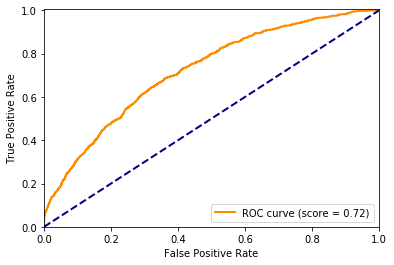

In [123]:
#fpr, tpr, threshold = skm.roc_curve(y_test, predictions)
fpr, tpr, threshold = skm.roc_curve(y_train, rnd_clf.predict_proba(X_train)[:,1])

fig = plt.figure()
lw = 2
roc_auc = skm.auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (score = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')            
plt.legend(loc="lower right")

plt.savefig("ROC_Score_withinsample.png")

In [ ]:
#Print out a file with the legislator_id, prob(entrepreneuer)

### Stratified

In [ ]:
ent = df[df['ent_any_x'] == 1]
non_ent = df[df['ent_any_x'] == 0].sample(n=1156)
df_strat = pd.concat([ent, non_ent])

X = df_strat[['age_at_election',
 'age_first',
 #'age_u1',
 #'age_u2',
 'recpi',
 'salary_norm',
 'ran_as',
 'ran_for',
 'gender',
 'degree1',
 'degree2']]
y = df_strat['ent_any_x']

degree_first = pd.get_dummies(X['degree1'],drop_first=True)
degree_second = pd.get_dummies(X['degree2'],drop_first=True)
gender = pd.get_dummies(X['gender'],drop_first=True)
ran_as = pd.get_dummies(X['ran_as'],drop_first=True)
ran_for = pd.get_dummies(X['ran_for'],drop_first=True)
X.drop(['degree1', 'degree2', 'gender', 'ran_as', 'ran_for'], axis=1, inplace=True)
X = pd.concat([X, degree_first, degree_second, gender, ran_as, ran_for],axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101, stratify=y.values)
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=1)
rnd_clf.fit(X_train,y_train)
predictions = rnd_clf.predict(X_test)
print(classification_report(y_test,predictions))

In [ ]:
y_train.value_counts()

# Dealing with Unbalanced Data

In [20]:
class Create_ensemble(object):
    # Number of Splits, Base Model
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models
    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        # Stratified K-Folds cross-validator
        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            for j, (train_idx, valid_idx) in enumerate(folds):
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
            
        return train_pred, test_pred, recall_scores, f1_scores

In [21]:
random_state = 101
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = random_state)
rdf = RandomForestClassifier(random_state = random_state) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'max_depth': [6, 8, 10, 20], 
              'min_samples_split': [5, 10, 15],
              'min_samples_leaf' : [4, 8, 12],
              'n_estimators' : [300, 400, 500]
             }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  7.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=101,
                                              verbose=0, warm_start=

In [22]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)
{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}


In [13]:
random_state = 101

In [23]:
rdf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

In [24]:
base_models = [rdf]
n_splits = 5
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models) 

In [25]:
# test = X_test.merge(y_test, how="left", left_index=True, right_index=True)

In [26]:
train_pred, test_pred, recall_scores, f1_scores = lgb_stack.predict(X_train, y_train, X_test)

Model- 0 and CV- 0 recall: 0.5, f1_score: 0.4815391459074733
Model- 0 and CV- 1 recall: 0.5, f1_score: 0.4815391459074733
Model- 0 and CV- 2 recall: 0.5, f1_score: 0.4815391459074733
Model- 0 and CV- 3 recall: 0.5, f1_score: 0.4815391459074733
Model- 0 and CV- 4 recall: 0.5, f1_score: 0.4815391459074733


In [27]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

1. The F-1 score of the model 0.4815391459074733

2. The recall score of the model 0.5

3. Classification report 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     10825
           1       0.00      0.00      0.00       830

    accuracy                           0.93     11655
   macro avg       0.46      0.50      0.48     11655
weighted avg       0.86      0.93      0.89     11655
 

4. Confusion matrix 
 [[10825     0]
 [  830     0]] 



In [28]:
print("Training Data ROC",skm.roc_auc_score(y_train,  rdf.predict(X_train)))
# print("Testing Data ROC",skm.roc_auc_score(y_test, predictions))

Training Data ROC 0.5


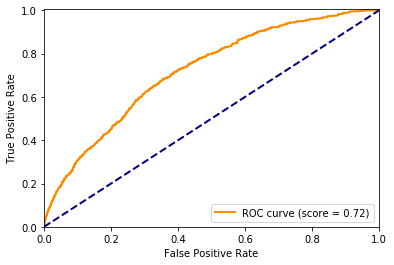

In [29]:
#fpr, tpr, threshold = skm.roc_curve(y_test, predictions)
fpr, tpr, threshold = skm.roc_curve(y_train, rdf.predict_proba(X_train)[:,1])

fig = plt.figure()
lw = 2
roc_auc = skm.auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (score = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')            
plt.legend(loc="lower right")

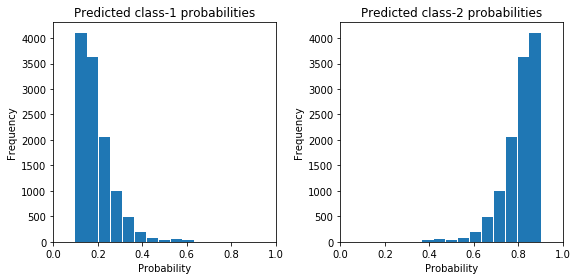

In [116]:
# histogram of predicted probabilities
plt.figure(figsize=(12, 4))
nclasses = 2
for i in range(nclasses):
    plt.subplot(1, 3, i+1)
    plt.hist(train_proba[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()